# Europe Single-Hour Network Analysis



Notebook for quick sanity checks and plots of the four-snapshot PyPSA-Earth test run.



## Sync the solved network (from repo root)

```bash

rsync -avz --progress \

  engs2523@arc-login.arc.ox.ac.uk:/data/engs-df-green-ammonia/engs2523/pypsa-earth/results/europe-single-hour/networks/elec_s_37_ec_lcopt_Co2L-3h.nc \

  results/europe-single-hour/networks/

```



## Suggested environment

```bash

mamba install -c conda-forge pypsa pandas xarray matplotlib cartopy geopandas shapely pyproj seaborn netcdf4

```

Cartopy/geopandas only needed for the geographic plots.

In [1]:
# Download natura raster on first run
import cartopy; from cartopy import feature as cf
cf.NaturalEarthFeature("physical","land","10m")

In [2]:
from pathlib import Path

candidate_paths = [
    Path('results/europe-single-hour/networks/elec_s_37_ec_lcopt_Co2L-3h.nc'),
    Path('..') / 'results' / 'europe-single-hour' / 'networks' / 'elec_s_37_ec_lcopt_Co2L-3h.nc'
]
RESULT_PATH = next((p for p in candidate_paths if p.exists()), None)
if RESULT_PATH is None:
    raise FileNotFoundError('Solved network missing. Run rsync in the first cell.')
print('Using network file:', RESULT_PATH.resolve())

Using network file: /Users/carlopalazzi/programming/pypsa_models/20251117-pypsa-earth-project/results/europe-single-hour/networks/elec_s_37_ec_lcopt_Co2L-3h.nc


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    import pypsa
except ImportError as exc:
    raise SystemExit('PyPSA missing. Install via mamba install -c conda-forge pypsa') from exc

try:
    import cartopy  # noqa: F401
    CARTOPY_AVAILABLE = True
except Exception:
    CARTOPY_AVAILABLE = False

print('PyPSA version:', pypsa.__version__)
print('Cartopy available:', CARTOPY_AVAILABLE)

PyPSA version: 0.28.0
Cartopy available: True


In [4]:
n = pypsa.Network(str(RESULT_PATH))
print(n)
print('Snapshots:', list(n.snapshots))
print('Buses:', len(n.buses), 'Lines:', len(n.lines), 'Generators:', len(n.generators))

INFO:pypsa.io:Imported network elec_s_37_ec_lcopt_Co2L-3h.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


PyPSA Network
Components:
 - Bus: 111
 - Carrier: 23
 - Generator: 215
 - GlobalConstraint: 1
 - Line: 44
 - Link: 148
 - Load: 37
 - StorageUnit: 3
 - Store: 74
Snapshots: 2
Snapshots: [Timestamp('2013-01-01 00:00:00'), Timestamp('2013-01-01 03:00:00')]
Buses: 111 Lines: 44 Generators: 215


## Installed capacities (MW)

In [5]:
cap_by_carrier = n.generators.groupby('carrier')['p_nom'].sum().sort_values(ascending=False)
cap_df = cap_by_carrier.to_frame(name='p_nom_MW')
cap_df

,p_nom_MW
carrier,
CCGT,13826.948035
load shedding,4983.288815
lignite,600.000000
coal,284.500000
oil,20.000000
offwind-ac,0.000000
offwind-dc,0.000000
onwind,0.000000
solar,0.000000


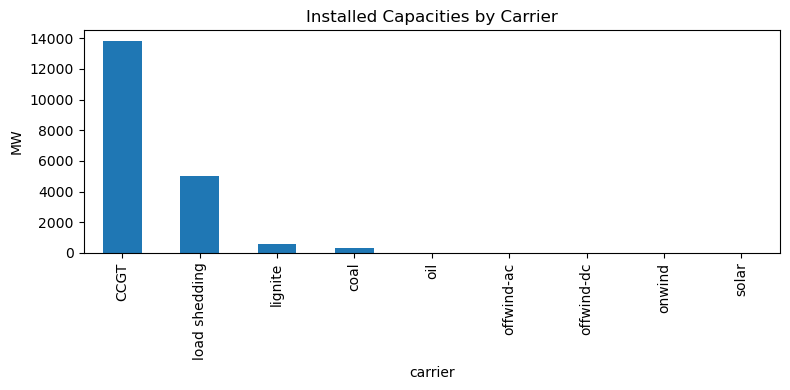

In [6]:
ax = cap_by_carrier.plot(kind='bar', figsize=(8, 4), title='Installed Capacities by Carrier')
ax.set_ylabel('MW')
plt.tight_layout()
plt.show()

## Generation mix (snapshot 0)

In [7]:
snap = n.snapshots[0]
tech_mix = n.generators_t.p.loc[snap].groupby(n.generators['carrier']).sum().sort_values(ascending=False)
tech_mix

carrier
onwind           3.065099e+03
lignite          6.000000e+02
coal             2.609345e-02
CCGT             5.399948e-04
oil              5.223644e-06
load shedding    4.952080e-08
offwind-ac       0.000000e+00
offwind-dc       0.000000e+00
solar            0.000000e+00
Name: 2013-01-01 00:00:00, dtype: float64

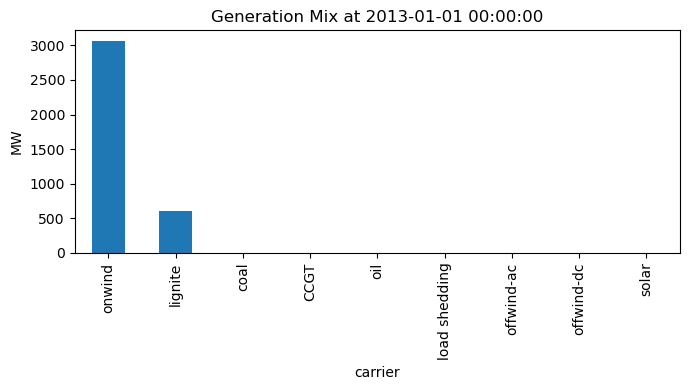

In [8]:
tech_mix.plot(kind='bar', figsize=(7, 4), title=f'Generation Mix at {snap}')
plt.ylabel('MW')
plt.tight_layout()
plt.show()

## Simple network map

/opt/homebrew/Caskroom/miniforge/base/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


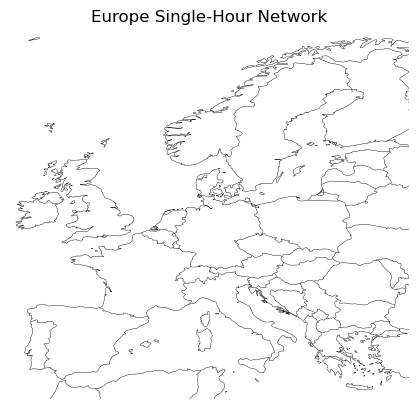

In [9]:
if CARTOPY_AVAILABLE:
    try:
        # scale factors tuned for visibility (increase if map still sparse)
        bus_sizes = (
            5e-5 * 100000000000  # adjust this multiplier to grow/shrink bus bubbles
            * n.loads.groupby("bus").p_set.max().reindex(n.buses.index).fillna(0.0)
        )
        line_widths = 1e-3 * n.lines.s_nom_opt.fillna(n.lines.s_nom)  * 10000000 # increase for thicker AC lines
        link_widths = 1e-3 * n.links.p_nom_opt.fillna(n.links.p_nom)  * 10000000 # increase for thicker DC links

        ax = n.plot(
            boundaries=(-11, 30, 34, 72),
            title="Europe Single-Hour Network",
            bus_sizes=bus_sizes,
            bus_colors="tab:orange",
            line_widths=line_widths,
            line_colors="steelblue",
            link_widths=link_widths,
            link_colors="slategray",
            branch_components={"Line", "Link"},
        )
        plt.show()
    except Exception as exc:
        print("Map plotting failed:", exc)
else:
    print("Cartopy not available; skipping geographic map.")

## Bus-level generation pies (snapshot 0)

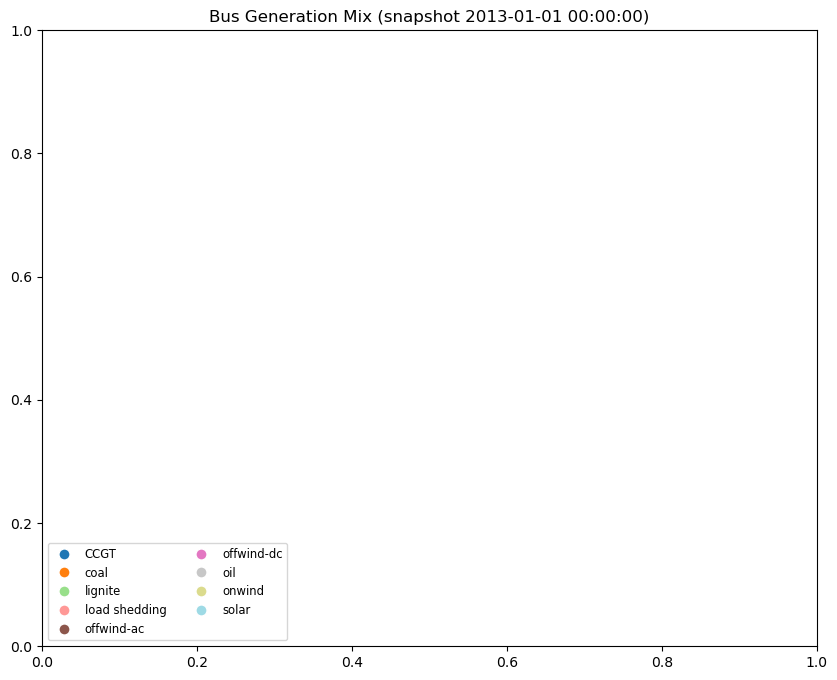

In [10]:
import numpy as np

if CARTOPY_AVAILABLE:
    gen_flow = n.generators_t.p.loc[snap]
    meta = n.generators[["bus", "carrier"]]
    df = pd.DataFrame({"p": gen_flow, "bus": meta.bus, "carrier": meta.carrier})
    pies = df.pivot_table(index="bus", columns="carrier", values="p", aggfunc="sum").fillna(0.0)
    pies = pies[pies.sum(axis=1) > 0]
    if len(pies) == 0:
        print("No generation at snapshot to plot pies.")
    else:
        from matplotlib.patches import Wedge

        fig, ax = plt.subplots(figsize=(10, 8))
        try:
            # scale multipliers control line thickness; bump up for denser maps
            line_widths = 8e-4 * n.lines.s_nom_opt.fillna(n.lines.s_nom)
            link_widths = 8e-4 * n.links.p_nom_opt.fillna(n.links.p_nom)
            n.plot(
                ax=ax,
                boundaries=(-11, 30, 34, 72),
                bus_sizes=0.0,
                line_widths=line_widths,
                line_colors="gainsboro",
                link_widths=link_widths,
                link_colors="lightsteelblue",
                branch_components={"Line", "Link"},
            )
        except Exception:
            pass
        carriers = pies.columns.tolist()
        colors = plt.cm.tab20(np.linspace(0, 1, len(carriers)))
        color_map = dict(zip(carriers, colors))
        max_total = pies.sum(axis=1).max()
        r_scale = 0.6 / max_total if max_total > 0 else 0.0  # change 0.6 to enlarge or shrink pies
        for bus, row in pies.iterrows():
            x = n.buses.loc[bus, "x"]
            y = n.buses.loc[bus, "y"]
            total = row.sum()
            if total <= 0:
                continue
            start = 0.0
            radius = total * r_scale
            for carrier in carriers:
                val = row.get(carrier, 0.0)
                if val <= 0:
                    continue
                angle = 360 * val / total
                wedge = Wedge((x, y), radius, start, start + angle, facecolor=color_map[carrier], edgecolor="white", linewidth=0.3)
                ax.add_patch(wedge)
                start += angle
        legend_handles = [
            plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map[c], label=c, markersize=8)
            for c in carriers
        ]
        ax.legend(handles=legend_handles, loc="lower left", fontsize="small", ncol=2)
        ax.set_title(f"Bus Generation Mix (snapshot {snap})")
        plt.show()
else:
    print("Cartopy not available; skipping pie map.")

## Line loading distribution

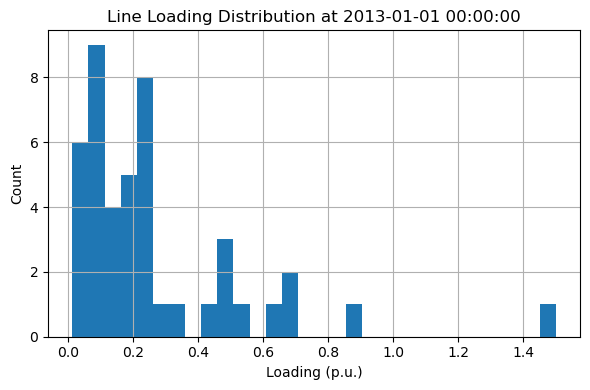

In [11]:
if 'p0' in n.lines_t:
    loading = (n.lines_t.p0.loc[snap].abs() / n.lines.s_nom).fillna(0.0)
    plt.figure(figsize=(6, 4))
    loading.clip(upper=1.5).hist(bins=30)
    plt.title(f'Line Loading Distribution at {snap}')
    plt.xlabel('Loading (p.u.)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print('Line flow results missing in network file.')

## Marginal prices

In [12]:
if 'marginal_price' in n.buses_t:
    prices = n.buses_t.marginal_price.loc[snap].dropna().sort_values(ascending=False)
    price_table = pd.DataFrame({
        'bus': prices.index,
        'price_EUR_per_MWh': prices.values
    })
    price_table.head(10)
else:
    print('No marginal prices stored in buses_t.')

## Objective value and cost breakdown

In [13]:
if hasattr(n, 'objective'):
    total_obj = float(n.objective / 1e6)
    print(f'Total objective: {total_obj:.2f} million EUR')
else:
    print('Objective attribute missing; using cost components only.')

gen_nom = n.generators.get('p_nom_opt', n.generators['p_nom'])
capex_gen = (gen_nom * n.generators.get('capital_cost', 0.0)).sum()

if len(n.stores):
    store_nom = n.stores.get('e_nom_opt', n.stores['e_nom'])
    capex_store = (store_nom * n.stores.get('capital_cost', 0.0)).sum()
else:
    capex_store = 0.0

if 'capital_cost' in n.lines.columns:
    line_nom = n.lines.get('s_nom_opt', n.lines['s_nom'])
    capex_lines = (line_nom * n.lines['capital_cost']).sum()
else:
    capex_lines = 0.0

operating_costs = (n.objective - (capex_gen + capex_store + capex_lines)) if hasattr(n, 'objective') else float('nan')

pd.Series({
    'generator_capex_EUR': capex_gen,
    'storage_capex_EUR': capex_store,
    'line_capex_EUR': capex_lines,
    'operating_costs_EUR': operating_costs
}) / 1e6

Total objective: 794.33 million EUR


Total objective: 794.33 million EUR


generator_capex_EUR    2471.030747
storage_capex_EUR         0.002101
line_capex_EUR          459.452751
operating_costs_EUR   -2136.151592
dtype: float64

## Notes
- Four-snapshot test is illustrative only.
- Extend to longer horizons or additional carriers via `config/default-single-timestep.yaml`.
- Add further aggregation cells (country mix, storage flows, etc.) as needed.

In [14]:
import pypsa
n = pypsa.Network("../results/europe-single-hour/networks/elec_s_37_ec_lcopt_Co2L-3h.nc")
assert n.buses[['x','y']].notna().all().all()

INFO:pypsa.io:Imported network elec_s_37_ec_lcopt_Co2L-3h.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [15]:
line_widths_raw = n.lines.s_nom_opt.fillna(n.lines.s_nom)
print("Lines with zero rating:", (line_widths_raw <= 0).sum(), " / ", len(line_widths_raw))
print("Bus coords missing:", n.buses[['x','y']].isna().any(axis=1).sum())
print("Load max per bus summary:")
print(n.loads.groupby("bus").p_set.max().describe())

Lines with zero rating: 0  /  44
Bus coords missing: 0
Load max per bus summary:
count    37.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: p_set, dtype: float64
